# Electron Photon tagging

Here I implement the improved QAE shown in 2112.04958 on the electron-photon Dataset

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
import h5py
from sklearn.model_selection import train_test_split
from hep_VQAE import QAE as qae

import warnings
warnings.filterwarnings('ignore')

2022-07-02 02:08:11.857313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-02 02:08:11.857332: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-02 02:08:12.857040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-02 02:08:12.857061: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-02 02:08:12.857075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-07-02 02:08:12.857265: I tensorflow/core/platform/cpu_fe

## Data

In [3]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

In [5]:
electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

In [6]:
x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [7]:
DOWNSCALE = 3
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_val, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_val, test_data=x_test)

In [8]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [9]:
x_train_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_train]
x_val_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_val]
x_test_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_test]

x_train_circuit_electrons = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_train_electrons]
x_val_circuit_electrons = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_val_electrons]
x_test_circuit_electrons = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_test_electrons]

In [10]:
x_train_tf = tfq.convert_to_tensor(x_train_circuit)
x_val_tf = tfq.convert_to_tensor(x_val_circuit)
x_test_tf = tfq.convert_to_tensor(x_test_circuit)

x_train_tf_electrons = tfq.convert_to_tensor(x_train_circuit_electrons)
x_val_tf_electrons = tfq.convert_to_tensor(x_val_circuit_electrons)
x_test_tf_electrons = tfq.convert_to_tensor(x_test_circuit_electrons)

## SQAE model

In [11]:
model = qae.SQAE_model(9,LATENT_BITS,7)

In [12]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))

In [13]:
y_train_ones = np.ones(shape=len(x_train_tf))
y_val_ones = np.ones(shape=len(x_val_tf))
y_test_ones = np.ones(shape=len(x_test_tf))

y_train_ones_electrons = np.ones(shape=len(x_train_tf_electrons))
y_val_ones_electrons = np.ones(shape=len(x_val_tf_electrons))
y_test_ones_electrons = np.ones(shape=len(x_test_tf_electrons))

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train_tf, y_train_ones, epochs=3, batch_size=64, validation_data=(x_val_tf, y_val_ones), callbacks=[es])

Epoch 1/3
1870/1870 [==============================] - 12455s 7s/step - loss: 0.0483 - val_loss: 0.0205
Epoch 2/3
1870/1870 [==============================] - 12380s 7s/step - loss: 0.0207 - val_loss: 0.0207
Epoch 3/3
1870/1870 [==============================] - 12534s 7s/step - loss: 0.0207 - val_loss: 0.0205


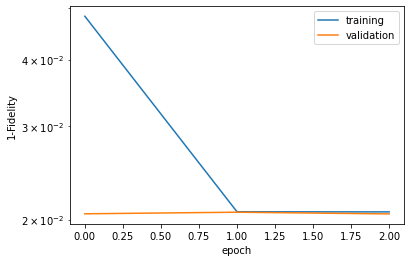

In [15]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("1-Fidelity")
plt.legend()

0.9102464
0.91650814


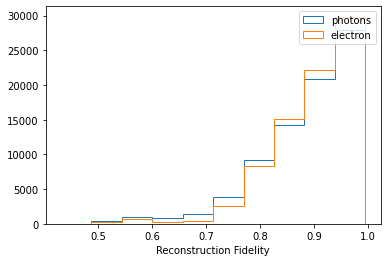

In [16]:
pred_photon = model.predict(x_test_tf)
print(np.median(pred_photon))
pred_electron = model.predict(x_test_tf_electrons)
print(np.median(pred_electron))
bins = np.histogram(np.hstack((pred_photon.reshape((pred_photon.shape[0],)), pred_electron.reshape((pred_electron.shape[0],)))), bins=10)[1]
plt.hist(pred_photon, histtype='step', label="photons",bins=bins)
plt.hist(pred_electron, histtype='step', label="electron",bins=bins)
plt.xlabel("Reconstruction Fidelity")
plt.legend()

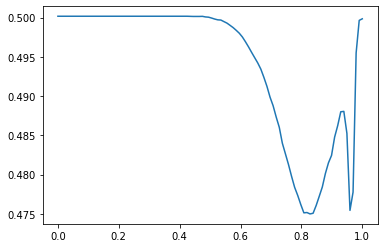

In [17]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_photon > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_electron < T)
    acc = (num_six_right + num_three_right)/(len(pred_photon) + len(pred_electron))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs)  